# Training with Freezing Layers

In [39]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import MeanAbsolutePercentageError  # Import the MAPE metric


csv_folder_path = '/Users/shubhibhadauriya/Desktop/Diss Project/osfstorage-archive (1)'  
image_base_path = '/Users/shubhibhadauriya/Desktop/osfstorage-archive'


image_width, image_height = 960, 960


csv_files = [f for f in os.listdir(csv_folder_path) if f.endswith('.csv')]


all_filenames = []
all_labels = []

# Function to find correct image file
def find_image_file(csv_filename, image_dir):
    parts = csv_filename.split('/')
    timestamp_id = parts[-1].split('-')[0]
    corrected_timestamp_id = timestamp_id.replace(':', '/')
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if corrected_timestamp_id in file:
                return os.path.join(root, file)
    return None

# Function to load images
def load_images(filenames, base_path):
    images = []
    for filename in filenames:
        img_path = find_image_file(filename, base_path)
        if img_path and os.path.exists(img_path):
            images.append(img_path)
        else:
            print(f"File not found for CSV entry: {filename}")
            images.append(None)  
    return np.array(images)

# Process each CSV file
for csv_file in csv_files:
    csv_file_path = os.path.join(csv_folder_path, csv_file)
    data = pd.read_csv(csv_file_path)
    data = data.dropna()
    data = data[data['lx'] !=1]
    data = data[data['lx'] >= 51]
    data = data[data['lx'] != data['ly']]
    def filter_invalid_w(data):
        data['w'] = np.sqrt((data['lx'] - data['rx'])**2 + (data['ly'] - data['ry'])**2)
        data = data[data['w'] > 0]
        data = data.drop(columns=['w'])
        return data
     
    

    # Normalize coordinates
    data['lx'] = data['lx'] / image_width
    data['ly'] = data['ly'] / image_height
    data['rx'] = data['rx'] / image_width
    data['ry'] = data['ry'] / image_height
    

    
    features = ['lx', 'ly', 'rx', 'ry']

    
    filenames = data['filename'].values
    images = load_images(filenames, image_base_path)
    labels = data[features].values

   
    valid_indices = [i for i, img in enumerate(images) if img is not None]
    images = images[valid_indices]
    labels = labels[valid_indices]

    
    all_filenames.extend(images)
    all_labels.extend(labels)


all_filenames = tf.convert_to_tensor(all_filenames, dtype=tf.string)
all_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)


dataset = tf.data.Dataset.from_tensor_slices((all_filenames, all_labels))


dataset = dataset.shuffle(buffer_size=len(all_filenames), seed=38)

sampled_dataset = dataset.take(1500)



train_size = int(0.6 * 1500)
val_size = int(0.4 * 1500)



print(train_size)
print(val_size)


train_dataset = sampled_dataset.take(train_size)
val_dataset = sampled_dataset.skip(train_size)
test_dataset = dataset.skip(train_size + val_size)


print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))





def load_and_preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = image / 255.0  
    
    
    return image, label


train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)


def data_augmentation(x):
    
    x = tf.image.random_contrast(x, lower=0.8, upper=1.2)  
    x = tf.image.random_brightness(x, max_delta=0.2)       
    
    return x


train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))



train_dataset = train_dataset.cache().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load the pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  

for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)  
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  
x = Dropout(0.6)(x) 
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(4, activation='linear')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# Custom relative error metric (e = d / w)
def euclidean_distance(true_coords, pred_coords):
    return tf.sqrt(tf.reduce_sum(tf.square(true_coords - pred_coords), axis=-1))



def calculate_relative_error(y_true, y_pred):
    # Denormalize both true and predicted coordinates back to their original scale
    y_true = y_true * [image_width, image_height, image_width, image_height]
    y_pred = y_pred * [image_width, image_height, image_width, image_height]

    true_lx, true_ly, true_rx, true_ry = tf.split(y_true, 4, axis=-1)
    pred_lx, pred_ly, pred_rx, pred_ry = tf.split(y_pred, 4, axis=-1)

    d_left_eye = euclidean_distance(tf.concat([true_lx, true_ly], axis=-1), 
                                    tf.concat([pred_lx, pred_ly], axis=-1))
    d_right_eye = euclidean_distance(tf.concat([true_rx, true_ry], axis=-1), 
                                     tf.concat([pred_rx, pred_ry], axis=-1))

    
    w = euclidean_distance(tf.concat([true_lx, true_ly], axis=-1), 
                           tf.concat([true_rx, true_ry], axis=-1))
    
   
    relative_error_left = d_left_eye / w
    relative_error_right = d_right_eye / w
    
    
    relative_error = tf.maximum(relative_error_left, relative_error_right)
    relative_error = tf.where(tf.math.is_inf(relative_error), 0.0, relative_error)
    
    return relative_error


optimizer = Adam(learning_rate=1e-3)  
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mae', MeanAbsolutePercentageError(name="mean_absolute_percentage_error"), calculate_relative_error])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)  
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,  
                    callbacks=[reduce_lr, checkpoint])


model.load_weights('best_model.keras')


def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='train_mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.title(f'{model_name} MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mean_absolute_percentage_error'], label='train_mape')
    plt.plot(history.history['val_mean_absolute_percentage_error'], label='val_mape')
    plt.title(f'{model_name} MAPE')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['calculate_relative_error'], label='train_relative_error')
    plt.plot(history.history['val_calculate_relative_error'], label='val_relative_error')
    plt.title(f'{model_name} Relative Error')




900
600
900
600
8574
Epoch 1/100
29/29 [==============================] - 509s 17s/step - loss: 2.8562 - mae: 0.3550 - mean_absolute_percentage_error: 76.0156 - calculate_relative_error: 1.4341 - val_loss: 2.1306 - val_mae: 0.3097 - val_mean_absolute_percentage_error: 60.1070 - val_calculate_relative_error: 1.2738 - lr: 0.0010
Epoch 2/100
29/29 [==============================] - 418s 15s/step - loss: 1.6927 - mae: 0.1900 - mean_absolute_percentage_error: 39.1898 - calculate_relative_error: 0.7568 - val_loss: 1.3564 - val_mae: 0.2499 - val_mean_absolute_percentage_error: 51.1347 - val_calculate_relative_error: 0.9589 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - 419s 15s/step - loss: 1.1142 - mae: 0.1545 - mean_absolute_percentage_error: 31.6438 - calculate_relative_error: 0.6194 - val_loss: 0.9480 - val_mae: 0.2482 - val_mean_absolute_percentage_error: 49.6384 - val_calculate_relative_error: 0.9736 - lr: 0.0010
Epoch 4/100
29/29 [==============================] - 41

29/29 [==============================] - 1108s 39s/step - loss: 0.0068 - mae: 0.0425 - mean_absolute_percentage_error: 9.5371 - calculate_relative_error: 0.1662 - val_loss: 0.0065 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.3948 - val_calculate_relative_error: 0.2014 - lr: 0.0010
Epoch 28/100
29/29 [==============================] - 1034s 36s/step - loss: 0.0061 - mae: 0.0425 - mean_absolute_percentage_error: 9.5328 - calculate_relative_error: 0.1658 - val_loss: 0.0059 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.3929 - val_calculate_relative_error: 0.2015 - lr: 0.0010
Epoch 29/100
29/29 [==============================] - 422s 15s/step - loss: 0.0056 - mae: 0.0424 - mean_absolute_percentage_error: 9.5183 - calculate_relative_error: 0.1658 - val_loss: 0.0054 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.4081 - val_calculate_relative_error: 0.2013 - lr: 0.0010
Epoch 30/100
29/29 [==============================] - 418s 15s/step - loss: 0.0051 - mae: 

Epoch 54/100
29/29 [==============================] - 513s 18s/step - loss: 0.0027 - mae: 0.0424 - mean_absolute_percentage_error: 9.5139 - calculate_relative_error: 0.1657 - val_loss: 0.0028 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.4329 - val_calculate_relative_error: 0.2012 - lr: 0.0010
Epoch 55/100
29/29 [==============================] - 530s 19s/step - loss: 0.0027 - mae: 0.0424 - mean_absolute_percentage_error: 9.5143 - calculate_relative_error: 0.1657 - val_loss: 0.0028 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.4322 - val_calculate_relative_error: 0.2012 - lr: 0.0010
Epoch 56/100
29/29 [==============================] - 433s 15s/step - loss: 0.0027 - mae: 0.0424 - mean_absolute_percentage_error: 9.5068 - calculate_relative_error: 0.1654 - val_loss: 0.0028 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.4235 - val_calculate_relative_error: 0.2015 - lr: 5.0000e-04
Epoch 57/100
29/29 [==============================] - 429s 15s/step - loss:

29/29 [==============================] - 566s 20s/step - loss: 0.0027 - mae: 0.0423 - mean_absolute_percentage_error: 9.5056 - calculate_relative_error: 0.1653 - val_loss: 0.0028 - val_mae: 0.0415 - val_mean_absolute_percentage_error: 9.4010 - val_calculate_relative_error: 0.2017 - lr: 3.1250e-05
Epoch 81/100
29/29 [==============================] - 502s 17s/step - loss: 0.0027 - mae: 0.0423 - mean_absolute_percentage_error: 9.5061 - calculate_relative_error: 0.1653 - val_loss: 0.0028 - val_mae: 0.0415 - val_mean_absolute_percentage_error: 9.4009 - val_calculate_relative_error: 0.2017 - lr: 1.5625e-05
Epoch 82/100
29/29 [==============================] - 433s 15s/step - loss: 0.0027 - mae: 0.0423 - mean_absolute_percentage_error: 9.5061 - calculate_relative_error: 0.1653 - val_loss: 0.0028 - val_mae: 0.0415 - val_mean_absolute_percentage_error: 9.4008 - val_calculate_relative_error: 0.2017 - lr: 1.5625e-05
Epoch 83/100
29/29 [==============================] - 433s 15s/step - loss: 0.00

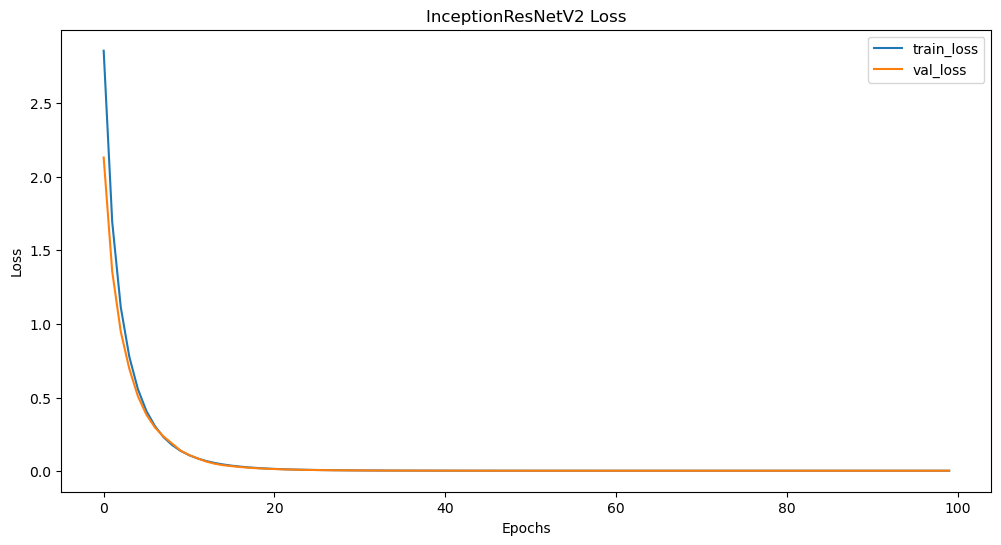

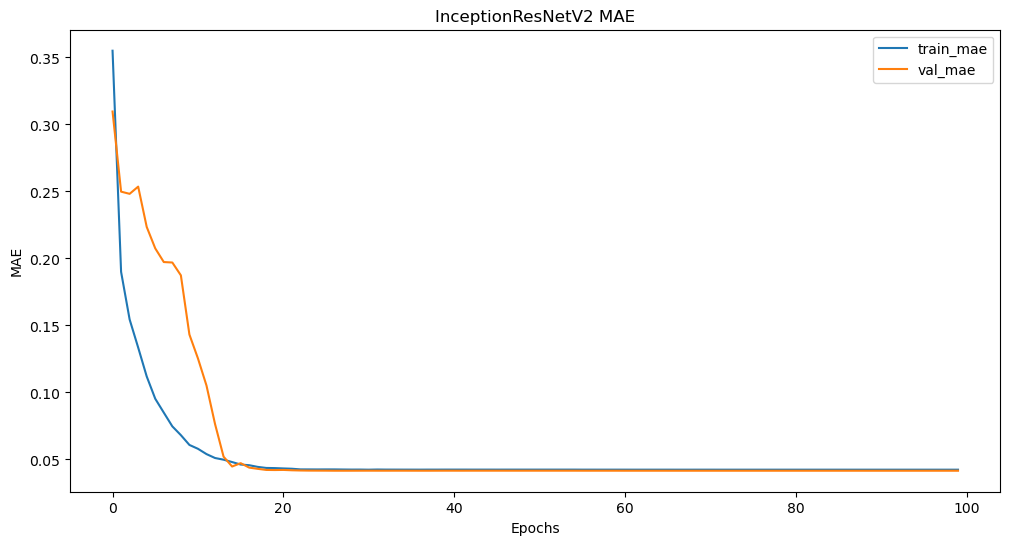

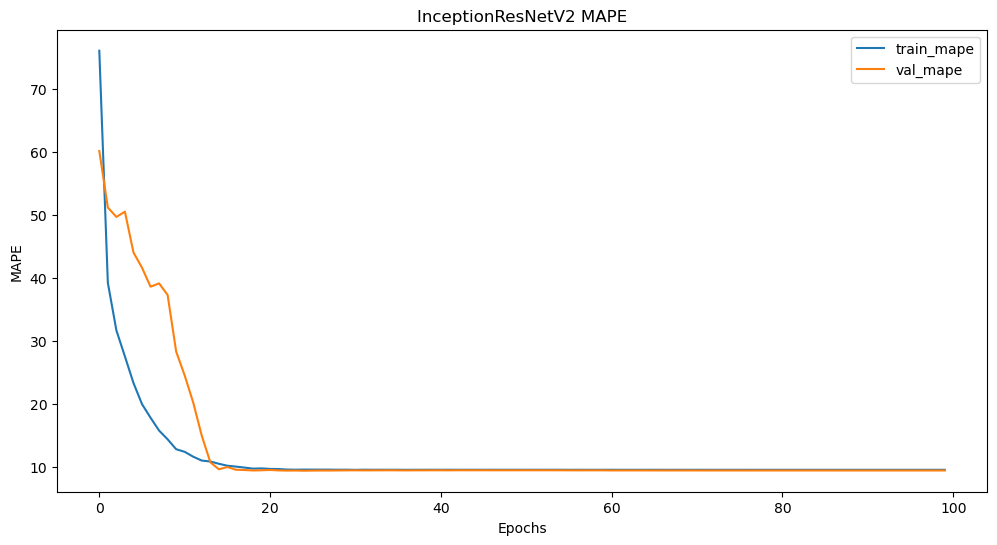

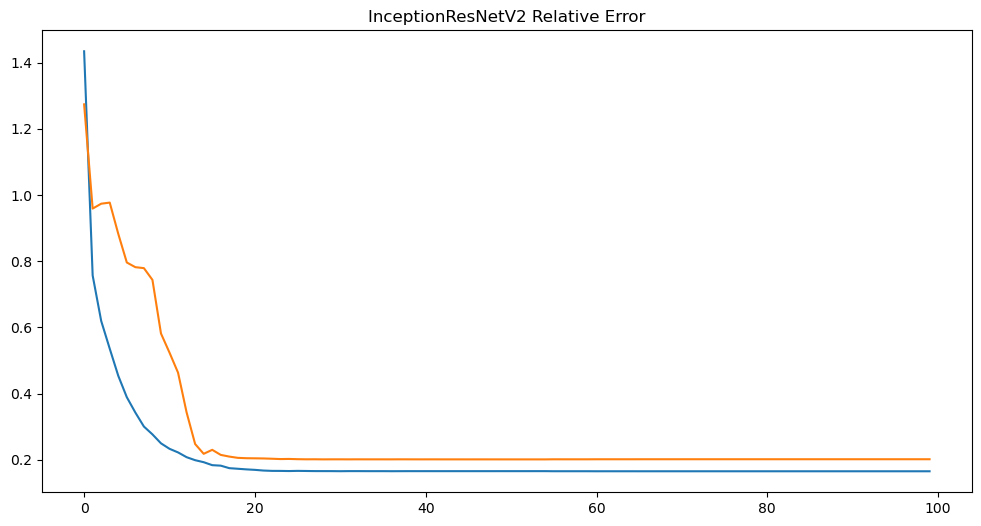

In [40]:
plot_history(history, 'InceptionResNetV2')

# Evaluation on Test Data with freezing layers

In [41]:

test_loss, test_mae, test_mape, test_relative_error = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}")
print(f"Test Relative Error: {test_relative_error}")

268/268 [==============================] - 3348s 12s/step - loss: 0.0027 - mae: 0.0424 - mean_absolute_percentage_error: 9.9288 - calculate_relative_error: 0.1592
Test Loss: 0.002739368937909603
Test MAE: 0.042368218302726746
Test MAPE: 9.928786277770996
Test Relative Error: 0.15917786955833435


# Relative Error Distribution on Test Data with freezing layers 

In [42]:
y_true_test = []
y_pred_test = []


for image_batch, label_batch in test_dataset:
    predictions = model(image_batch, training=False)
    y_true_test.append(label_batch)
    y_pred_test.append(predictions)


y_true_test = tf.concat(y_true_test, axis=0)
y_pred_test = tf.concat(y_pred_test, axis=0)


y_true_test = y_true_test * [image_width, image_height, image_width, image_height]  
y_pred_test = y_pred_test * [image_width, image_height, image_width, image_height]  


def euclidean_distance_test_tf(true_coords, pred_coords):
    return tf.sqrt(tf.reduce_sum(tf.square(true_coords - pred_coords), axis=-1))


d_left_eye_test = euclidean_distance_test_tf(y_true_test[:, :2], y_pred_test[:, :2])
d_right_eye_test = euclidean_distance_test_tf(y_true_test[:, 2:], y_pred_test[:, 2:])


w = euclidean_distance_test_tf(y_true_test[:, :2], y_true_test[:, 2:])




relative_error_left_test = d_left_eye_test / w
relative_error_right_test = d_right_eye_test / w


relative_error_test= tf.maximum(relative_error_left_test, relative_error_right_test)
relative_error_test = tf.where(tf.math.is_inf(relative_error_test), 0.0, relative_error_test)


relative_error_np = relative_error_test.numpy()


print(f"All relative error values: {relative_error_np}")






print(f"Number of samples with relative error less than 0: {(relative_error_np < 0).sum()}")
print(f"Number of samples with relative error equal to 0: {(relative_error_np == 0).sum()}")
print(f"Number of samples with relative error between 0 and 0.01: {((0 < relative_error_np) & (relative_error_np <= 0.01)).sum()}")
print(f"Number of samples with relative error between 0.01 and 0.025: {((0.01 < relative_error_np) & (relative_error_np <= 0.025)).sum()}")
print(f"Number of samples with relative error between 0.025 and 0.05: {((0.025 < relative_error_np) & (relative_error_np <= 0.05)).sum()}")
print(f"Number of samples with relative error between 0.05 and 0.1: {((0.05 < relative_error_np) & (relative_error_np <= 0.1)).sum()}")
print(f"Number of samples with relative error between 0.1 and 0.25: {((0.1 < relative_error_np) & (relative_error_np <= 0.25)).sum()}")
print(f"Number of samples with relative error between 0.25 and 0.3: {((0.25 < relative_error_np) & (relative_error_np <= 0.3)).sum()}")
print(f"Number of samples with relative error between 0.3 and 0.35: {((0.3 < relative_error_np) & (relative_error_np <= 0.35)).sum()}")
print(f"Number of samples with relative error greater than 0.35: {(relative_error_np >0.35).sum()}")


print(f"Number of samples with relative error between 0 and 0.1: {((0 < relative_error_np) & (relative_error_np <= 0.1)).sum()}")
print(f"Number of samples with relative error between 0.1 and 0.2: {((0.1 < relative_error_np) & (relative_error_np <= 0.2)).sum()}")
print(f"Number of samples with relative error between 0.2 and 0.3: {((0.2 < relative_error_np) & (relative_error_np <= 0.3)).sum()}")

print(f"Number of samples with relative error between 0.3 and 0.4: {((0.3 < relative_error_np) & (relative_error_np <= 0.4)).sum()}")
print(f"Number of samples with relative error between 0.4 and 0.5: {((0.4 < relative_error_np) & (relative_error_np <= 0.5)).sum()}")
print(f"Number of samples with relative error between 0.5 and 0.6: {((0.5 < relative_error_np) & (relative_error_np <= 0.6)).sum()}")
print(f"Number of samples with relative error between 0.6 and 0.7: {((0.6 < relative_error_np) & (relative_error_np <= 0.7)).sum()}")
print(f"Number of samples with relative error between 0.7 and 0.8: {((0.7 < relative_error_np) & (relative_error_np <= 0.8)).sum()}")
print(f"Number of samples with relative error between 0.8 and 0.9: {((0.8 < relative_error_np) & (relative_error_np <= 0.9)).sum()}")
print(f"Number of samples with relative error between 0.9 and 1.0: {((0.9 < relative_error_np) & (relative_error_np <= 1.0)).sum()}")

print(f"Number of samples with relative error greater than 1.0: {(relative_error_np >1.0).sum()}")

All relative error values: [0.1409954  0.06053939 0.15702675 ... 0.07812975 0.13691089 0.28447682]
Number of samples with relative error less than 0: 0
Number of samples with relative error equal to 0: 2
Number of samples with relative error between 0 and 0.01: 2
Number of samples with relative error between 0.01 and 0.025: 26
Number of samples with relative error between 0.025 and 0.05: 235
Number of samples with relative error between 0.05 and 0.1: 1556
Number of samples with relative error between 0.1 and 0.25: 6145
Number of samples with relative error between 0.25 and 0.3: 447
Number of samples with relative error between 0.3 and 0.35: 117
Number of samples with relative error greater than 0.35: 44
Number of samples with relative error between 0 and 0.1: 1819
Number of samples with relative error between 0.1 and 0.2: 4960
Number of samples with relative error between 0.2 and 0.3: 1632
Number of samples with relative error between 0.3 and 0.4: 143
Number of samples with relative er

# Training with unfreezing layers

In [44]:

base_model.trainable = True


model.summary(show_trainable=True)


model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss='mse', 
    metrics=['mae', MeanAbsolutePercentageError(name="mean_absolute_percentage_error"), calculate_relative_error] 
)


epochs = 20

print("Fitting the end-to-end model with fine-tuning")


model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=val_dataset, 
    callbacks=[reduce_lr, checkpoint] 
)


model.load_weights('best_model.keras')




Model: "model_12"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_13 (InputLayer)          [(None, 299, 299, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv2d_2436 (Conv2D)           (None, 149, 149, 32  864         ['input_13[0][0]']               Y          
                                )                                                                            
                                                                                                             
 batch_normalization_2436 (Batc  (None, 149, 149, 32  96         ['conv2d_2436[0][0]']            Y   

                                                                                                             
 activation_2445 (Activation)   (None, 35, 35, 96)   0           ['batch_normalization_2445[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 average_pooling2d_12 (AverageP  (None, 35, 35, 192)  0          ['max_pooling2d_49[0][0]']       Y          
 ooling2D)                                                                                                   
                                                                                                             
 conv2d_2441 (Conv2D)           (None, 35, 35, 96)   18432       ['max_pooling2d_49[0][0]']       Y          
                                                                                                             
 conv2d_24

 hNormalization)                                                                                             
                                                                                                             
 batch_normalization_2450 (Batc  (None, 35, 35, 32)  96          ['conv2d_2450[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 batch_normalization_2453 (Batc  (None, 35, 35, 64)  192         ['conv2d_2453[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2448 (Activation)   (None, 35, 35, 32)   0           ['batch_normalization_2448[0][0  Y          
          

                                                                                                             
 block35_2_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_2454[0][0]',        Y          
                                                                  'activation_2456[0][0]',                   
                                                                  'activation_2459[0][0]']                   
                                                                                                             
 block35_2_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_2_mixed[0][0]']        Y          
                                                                                                             
 block35_2 (Lambda)             (None, 35, 35, 320)  0           ['block35_1_ac[0][0]',           Y          
                                                                  'block35_2_conv[0][0]']                    
          

                                                                                                             
 activation_2469 (Activation)   (None, 35, 35, 32)   0           ['batch_normalization_2469[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 conv2d_2467 (Conv2D)           (None, 35, 35, 32)   10240       ['block35_3_ac[0][0]']           Y          
                                                                                                             
 conv2d_2470 (Conv2D)           (None, 35, 35, 48)   13824       ['activation_2469[0][0]']        Y          
                                                                                                             
 batch_normalization_2467 (Batc  (None, 35, 35, 32)  96          ['conv2d_2467[0][0]']            Y          
 hNormaliz

                                                                                                             
 activation_2476 (Activation)   (None, 35, 35, 48)   0           ['batch_normalization_2476[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 conv2d_2472 (Conv2D)           (None, 35, 35, 32)   10240       ['block35_4_ac[0][0]']           Y          
                                                                                                             
 conv2d_2474 (Conv2D)           (None, 35, 35, 32)   9216        ['activation_2473[0][0]']        Y          
                                                                                                             
 conv2d_2477 (Conv2D)           (None, 35, 35, 64)   27648       ['activation_2476[0][0]']        Y          
          

 batch_normalization_2483 (Batc  (None, 35, 35, 64)  192         ['conv2d_2483[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2478 (Activation)   (None, 35, 35, 32)   0           ['batch_normalization_2478[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 activation_2480 (Activation)   (None, 35, 35, 32)   0           ['batch_normalization_2480[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 activatio

 block35_7_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_7_mixed[0][0]']        Y          
                                                                                                             
 block35_7 (Lambda)             (None, 35, 35, 320)  0           ['block35_6_ac[0][0]',           Y          
                                                                  'block35_7_conv[0][0]']                    
                                                                                                             
 block35_7_ac (Activation)      (None, 35, 35, 320)  0           ['block35_7[0][0]']              Y          
                                                                                                             
 conv2d_2493 (Conv2D)           (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           Y          
                                                                                                             
 batch_nor

                                                                                                             
 conv2d_2500 (Conv2D)           (None, 35, 35, 48)   13824       ['activation_2499[0][0]']        Y          
                                                                                                             
 batch_normalization_2497 (Batc  (None, 35, 35, 32)  96          ['conv2d_2497[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 batch_normalization_2500 (Batc  (None, 35, 35, 48)  144         ['conv2d_2500[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activatio

                                                                                                             
 conv2d_2504 (Conv2D)           (None, 35, 35, 32)   9216        ['activation_2503[0][0]']        Y          
                                                                                                             
 conv2d_2507 (Conv2D)           (None, 35, 35, 64)   27648       ['activation_2506[0][0]']        Y          
                                                                                                             
 batch_normalization_2502 (Batc  (None, 35, 35, 32)  96          ['conv2d_2502[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 batch_normalization_2504 (Batc  (None, 35, 35, 32)  96          ['conv2d_2504[0][0]']            Y          
 hNormaliz

 batch_normalization_2513 (Batc  (None, 17, 17, 128)  384        ['conv2d_2513[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2513 (Activation)   (None, 17, 17, 128)  0           ['batch_normalization_2513[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 conv2d_2514 (Conv2D)           (None, 17, 17, 160)  143360      ['activation_2513[0][0]']        Y          
                                                                                                             
 batch_normalization_2514 (Batc  (None, 17, 17, 160)  480        ['conv2d_2514[0][0]']            Y          
 hNormaliz

                                                                  'activation_2519[0][0]']                   
                                                                                                             
 block17_2_conv (Conv2D)        (None, 17, 17, 1088  418880      ['block17_2_mixed[0][0]']        Y          
                                )                                                                            
                                                                                                             
 block17_2 (Lambda)             (None, 17, 17, 1088  0           ['block17_1_ac[0][0]',           Y          
                                )                                 'block17_2_conv[0][0]']                    
                                                                                                             
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              Y          
          

 batch_normalization_2524 (Batc  (None, 17, 17, 192)  576        ['conv2d_2524[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 batch_normalization_2527 (Batc  (None, 17, 17, 192)  576        ['conv2d_2527[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2524 (Activation)   (None, 17, 17, 192)  0           ['batch_normalization_2524[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 activatio

                                                                                                             
 conv2d_2534 (Conv2D)           (None, 17, 17, 160)  143360      ['activation_2533[0][0]']        Y          
                                                                                                             
 batch_normalization_2534 (Batc  (None, 17, 17, 160)  480        ['conv2d_2534[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2534 (Activation)   (None, 17, 17, 160)  0           ['batch_normalization_2534[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 conv2d_25

 block17_7 (Lambda)             (None, 17, 17, 1088  0           ['block17_6_ac[0][0]',           Y          
                                )                                 'block17_7_conv[0][0]']                    
                                                                                                             
 block17_7_ac (Activation)      (None, 17, 17, 1088  0           ['block17_7[0][0]']              Y          
                                )                                                                            
                                                                                                             
 conv2d_2541 (Conv2D)           (None, 17, 17, 128)  139264      ['block17_7_ac[0][0]']           Y          
                                                                                                             
 batch_normalization_2541 (Batc  (None, 17, 17, 128)  384        ['conv2d_2541[0][0]']            Y          
 hNormaliz

                                                                                                             
 activation_2544 (Activation)   (None, 17, 17, 192)  0           ['batch_normalization_2544[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 activation_2547 (Activation)   (None, 17, 17, 192)  0           ['batch_normalization_2547[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 block17_9_mixed (Concatenate)  (None, 17, 17, 384)  0           ['activation_2544[0][0]',        Y          
                                                                  'activation_2547[0][0]']                   
          

                                                                                                             
 activation_2554 (Activation)   (None, 17, 17, 160)  0           ['batch_normalization_2554[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 conv2d_2552 (Conv2D)           (None, 17, 17, 192)  208896      ['block17_10_ac[0][0]']          Y          
                                                                                                             
 conv2d_2555 (Conv2D)           (None, 17, 17, 192)  215040      ['activation_2554[0][0]']        Y          
                                                                                                             
 batch_normalization_2552 (Batc  (None, 17, 17, 192)  576        ['conv2d_2552[0][0]']            Y          
 hNormaliz

                                                                                                             
 conv2d_2561 (Conv2D)           (None, 17, 17, 128)  139264      ['block17_12_ac[0][0]']          Y          
                                                                                                             
 batch_normalization_2561 (Batc  (None, 17, 17, 128)  384        ['conv2d_2561[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2561 (Activation)   (None, 17, 17, 128)  0           ['batch_normalization_2561[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 conv2d_25

                                                                 ]']                                         
                                                                                                             
 block17_14_mixed (Concatenate)  (None, 17, 17, 384)  0          ['activation_2564[0][0]',        Y          
                                                                  'activation_2567[0][0]']                   
                                                                                                             
 block17_14_conv (Conv2D)       (None, 17, 17, 1088  418880      ['block17_14_mixed[0][0]']       Y          
                                )                                                                            
                                                                                                             
 block17_14 (Lambda)            (None, 17, 17, 1088  0           ['block17_13_ac[0][0]',          Y          
          

                                                                                                             
 conv2d_2575 (Conv2D)           (None, 17, 17, 192)  215040      ['activation_2574[0][0]']        Y          
                                                                                                             
 batch_normalization_2572 (Batc  (None, 17, 17, 192)  576        ['conv2d_2572[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 batch_normalization_2575 (Batc  (None, 17, 17, 192)  576        ['conv2d_2575[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activatio

                                                                                                             
 activation_2581 (Activation)   (None, 17, 17, 128)  0           ['batch_normalization_2581[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 conv2d_2582 (Conv2D)           (None, 17, 17, 160)  143360      ['activation_2581[0][0]']        Y          
                                                                                                             
 batch_normalization_2582 (Batc  (None, 17, 17, 160)  480        ['conv2d_2582[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activatio

 block17_19_conv (Conv2D)       (None, 17, 17, 1088  418880      ['block17_19_mixed[0][0]']       Y          
                                )                                                                            
                                                                                                             
 block17_19 (Lambda)            (None, 17, 17, 1088  0           ['block17_18_ac[0][0]',          Y          
                                )                                 'block17_19_conv[0][0]']                   
                                                                                                             
 block17_19_ac (Activation)     (None, 17, 17, 1088  0           ['block17_19[0][0]']             Y          
                                )                                                                            
                                                                                                             
 conv2d_25

                                                                                                             
 activation_2592 (Activation)   (None, 17, 17, 256)  0           ['batch_normalization_2592[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 activation_2594 (Activation)   (None, 17, 17, 256)  0           ['batch_normalization_2594[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 activation_2597 (Activation)   (None, 17, 17, 288)  0           ['batch_normalization_2597[0][0  Y          
                                                                 ]']                                         
          

                                                                  'activation_2602[0][0]']                   
                                                                                                             
 block8_1_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_1_mixed[0][0]']         Y          
                                                                                                             
 block8_1 (Lambda)              (None, 8, 8, 2080)   0           ['mixed_7a[0][0]',               Y          
                                                                  'block8_1_conv[0][0]']                     
                                                                                                             
 block8_1_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_1[0][0]']               Y          
                                                                                                             
 conv2d_26

 hNormalization)                                                                                             
                                                                                                             
 activation_2607 (Activation)   (None, 8, 8, 192)    0           ['batch_normalization_2607[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 activation_2610 (Activation)   (None, 8, 8, 256)    0           ['batch_normalization_2610[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 block8_3_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_2607[0][0]',        Y          
          

                                                                                                             
 conv2d_2615 (Conv2D)           (None, 8, 8, 192)    399360      ['block8_4_ac[0][0]']            Y          
                                                                                                             
 conv2d_2618 (Conv2D)           (None, 8, 8, 256)    172032      ['activation_2617[0][0]']        Y          
                                                                                                             
 batch_normalization_2615 (Batc  (None, 8, 8, 192)   576         ['conv2d_2615[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 batch_normalization_2618 (Batc  (None, 8, 8, 256)   768         ['conv2d_2618[0][0]']            Y          
 hNormaliz

                                                                 ]']                                         
                                                                                                             
 conv2d_2625 (Conv2D)           (None, 8, 8, 224)    129024      ['activation_2624[0][0]']        Y          
                                                                                                             
 batch_normalization_2625 (Batc  (None, 8, 8, 224)   672         ['conv2d_2625[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2625 (Activation)   (None, 8, 8, 224)    0           ['batch_normalization_2625[0][0  Y          
                                                                 ]']                                         
          

                                                                                                             
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               Y          
                                                                                                             
 conv2d_2632 (Conv2D)           (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            Y          
                                                                                                             
 batch_normalization_2632 (Batc  (None, 8, 8, 192)   576         ['conv2d_2632[0][0]']            Y          
 hNormalization)                                                                                             
                                                                                                             
 activation_2632 (Activation)   (None, 8, 8, 192)    0           ['batch_normalization_2632[0][0  Y          
          

                                                                 ]']                                         
                                                                                                             
 block8_10_mixed (Concatenate)  (None, 8, 8, 448)    0           ['activation_2635[0][0]',        Y          
                                                                  'activation_2638[0][0]']                   
                                                                                                             
 block8_10_conv (Conv2D)        (None, 8, 8, 2080)   933920      ['block8_10_mixed[0][0]']        Y          
                                                                                                             
 block8_10 (Lambda)             (None, 8, 8, 2080)   0           ['block8_9_ac[0][0]',            Y          
                                                                  'block8_10_conv[0][0]']                    
          

29/29 [==============================] - 1409s 49s/step - loss: 0.0027 - mae: 0.0423 - mean_absolute_percentage_error: 9.5086 - calculate_relative_error: 0.1653 - val_loss: 0.0028 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.4083 - val_calculate_relative_error: 0.2016 - lr: 1.0000e-05
Epoch 16/20
29/29 [==============================] - 1399s 48s/step - loss: 0.0027 - mae: 0.0423 - mean_absolute_percentage_error: 9.5133 - calculate_relative_error: 0.1652 - val_loss: 0.0028 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.4082 - val_calculate_relative_error: 0.2016 - lr: 1.0000e-05
Epoch 17/20
29/29 [==============================] - 1511s 52s/step - loss: 0.0027 - mae: 0.0423 - mean_absolute_percentage_error: 9.5073 - calculate_relative_error: 0.1652 - val_loss: 0.0028 - val_mae: 0.0416 - val_mean_absolute_percentage_error: 9.4051 - val_calculate_relative_error: 0.2016 - lr: 1.0000e-05
Epoch 18/20
29/29 [==============================] - 1966s 68s/step - loss: 0.0

# Evaluation on Test Data with unfreezing layers

In [46]:

test_loss, test_mae, test_mape, test_relative_error = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}")
print(f"Test Relative Error: {test_relative_error}")

268/268 [==============================] - 3038s 11s/step - loss: 0.0027 - mae: 0.0424 - mean_absolute_percentage_error: 9.9569 - calculate_relative_error: 0.1592
Test Loss: 0.0027315402403473854
Test MAE: 0.04240947216749191
Test MAPE: 9.956900596618652
Test Relative Error: 0.15922845900058746


# Relative Error Distribution of Test Data with unfreezing layers

In [47]:
y_true_test = []
y_pred_test = []

for image_batch, label_batch in test_dataset:
    
    predictions = model(image_batch, training=False)
    y_true_test.append(label_batch)
    y_pred_test.append(predictions)


y_true_test = tf.concat(y_true_test, axis=0)
y_pred_test = tf.concat(y_pred_test, axis=0)


y_true_test = y_true_test * [image_width, image_height, image_width, image_height]  
y_pred_test = y_pred_test * [image_width, image_height, image_width, image_height]  


def euclidean_distance_test_tf(true_coords, pred_coords):
    return tf.sqrt(tf.reduce_sum(tf.square(true_coords - pred_coords), axis=-1))


d_left_eye_test = euclidean_distance_test_tf(y_true_test[:, :2], y_pred_test[:, :2])
d_right_eye_test = euclidean_distance_test_tf(y_true_test[:, 2:], y_pred_test[:, 2:])


w = euclidean_distance_test_tf(y_true_test[:, :2], y_true_test[:, 2:])




relative_error_left_test = d_left_eye_test / w
relative_error_right_test = d_right_eye_test / w


relative_error_test= tf.maximum(relative_error_left_test, relative_error_right_test)
relative_error_test = tf.where(tf.math.is_inf(relative_error_test), 0.0, relative_error_test)


relative_error_np = relative_error_test.numpy()



print(f"All relative error values: {relative_error_np}")






print(f"Number of samples with relative error less than 0: {(relative_error_np < 0).sum()}")
print(f"Number of samples with relative error equal to 0: {(relative_error_np == 0).sum()}")
print(f"Number of samples with relative error between 0 and 0.01: {((0 < relative_error_np) & (relative_error_np <= 0.01)).sum()}")
print(f"Number of samples with relative error between 0.01 and 0.025: {((0.01 < relative_error_np) & (relative_error_np <= 0.025)).sum()}")
print(f"Number of samples with relative error between 0.025 and 0.05: {((0.025 < relative_error_np) & (relative_error_np <= 0.05)).sum()}")
print(f"Number of samples with relative error between 0.05 and 0.1: {((0.05 < relative_error_np) & (relative_error_np <= 0.1)).sum()}")
print(f"Number of samples with relative error between 0.1 and 0.25: {((0.1 < relative_error_np) & (relative_error_np <= 0.25)).sum()}")
print(f"Number of samples with relative error between 0.25 and 0.3: {((0.25 < relative_error_np) & (relative_error_np <= 0.3)).sum()}")
print(f"Number of samples with relative error between 0.3 and 0.35: {((0.3 < relative_error_np) & (relative_error_np <= 0.35)).sum()}")
print(f"Number of samples with relative error greater than 0.35: {(relative_error_np >0.35).sum()}")


print(f"Number of samples with relative error between 0 and 0.1: {((0 < relative_error_np) & (relative_error_np <= 0.1)).sum()}")
print(f"Number of samples with relative error between 0.1 and 0.2: {((0.1 < relative_error_np) & (relative_error_np <= 0.2)).sum()}")
print(f"Number of samples with relative error between 0.2 and 0.3: {((0.2 < relative_error_np) & (relative_error_np <= 0.3)).sum()}")

print(f"Number of samples with relative error between 0.3 and 0.4: {((0.3 < relative_error_np) & (relative_error_np <= 0.4)).sum()}")
print(f"Number of samples with relative error between 0.4 and 0.5: {((0.4 < relative_error_np) & (relative_error_np <= 0.5)).sum()}")
print(f"Number of samples with relative error between 0.5 and 0.6: {((0.5 < relative_error_np) & (relative_error_np <= 0.6)).sum()}")
print(f"Number of samples with relative error between 0.6 and 0.7: {((0.6 < relative_error_np) & (relative_error_np <= 0.7)).sum()}")
print(f"Number of samples with relative error between 0.7 and 0.8: {((0.7 < relative_error_np) & (relative_error_np <= 0.8)).sum()}")
print(f"Number of samples with relative error between 0.8 and 0.9: {((0.8 < relative_error_np) & (relative_error_np <= 0.9)).sum()}")
print(f"Number of samples with relative error between 0.9 and 1.0: {((0.9 < relative_error_np) & (relative_error_np <= 1.0)).sum()}")

print(f"Number of samples with relative error greater than 1.0: {(relative_error_np >1.0).sum()}")


All relative error values: [0.13903145 0.05850124 0.15793729 ... 0.07649063 0.13772684 0.28249428]
Number of samples with relative error less than 0: 0
Number of samples with relative error equal to 0: 2
Number of samples with relative error between 0 and 0.01: 4
Number of samples with relative error between 0.01 and 0.025: 23
Number of samples with relative error between 0.025 and 0.05: 231
Number of samples with relative error between 0.05 and 0.1: 1561
Number of samples with relative error between 0.1 and 0.25: 6146
Number of samples with relative error between 0.25 and 0.3: 446
Number of samples with relative error between 0.3 and 0.35: 118
Number of samples with relative error greater than 0.35: 43
Number of samples with relative error between 0 and 0.1: 1819
Number of samples with relative error between 0.1 and 0.2: 4951
Number of samples with relative error between 0.2 and 0.3: 1641
Number of samples with relative error between 0.3 and 0.4: 143
Number of samples with relative er